<img src="http://oproject.org/tiki-download_file.php?fileId=8&display&x=450&y=128">
<img src="http://files.oproject.org/tmvalogo.png" height="50%" width="50%">

# TMVA Classification Example Using a Convolutional Neural Network

## Declare Factory

Create the Factory class. Later you can choose the methods
whose performance you'd like to investigate. 

The factory is the major TMVA object you have to interact with. Here is the list of parameters you need to pass

 - The first argument is the base of the name of all the output
weightfiles in the directory weight/ that will be created with the 
method parameters 

 - The second argument is the output file for the training results
  
 - The third argument is a string option defining some general configuration for the TMVA session. For example all TMVA output can be suppressed by removing the "!" (not) in front of the "Silent" argument in the option string

In [1]:
TMVA::Tools::Instance();

 // for using Keras
gSystem->Setenv("KERAS_BACKEND","tensorflow"); 
TMVA::PyMethodBase::PyInitialize();



auto outputFile = TFile::Open("CNN_ClassificationOutput.root", "RECREATE");

TMVA::Factory factory("TMVA_CNN_Classification", outputFile,
                      "!V:ROC:!Silent:Color:!DrawProgressBar:AnalysisType=Classification" ); 


## Declare DataLoader(s)

The next step is to declare the DataLoader class that deals with input variables 

Define the input variables that shall be used for the MVA training
note that you may also use variable expressions, which can be parsed by TTree::Draw( "expression" )]

In this case the input data consists of an image of 16x16 pixels. Each single pixel is a branch in a ROOT TTree

In [2]:
TMVA::DataLoader * loader = new TMVA::DataLoader("dataset");

int imgSize = 8 * 8; 
for(auto i = 0; i < imgSize; i++)
 {
     loader->AddVariable(Form("var%d",i),'F');
 }

## Setup Dataset(s)

Define input data file and signal and background trees

In [3]:
TString inputFileName = "images_data.root";

//TString inputFileName = "tmva_class_example.root";

auto inputFile = TFile::Open( inputFileName );

// --- Register the training and test trees

TTree *signalTree     = (TTree*)inputFile->Get("sig_tree");
TTree *backgroundTree = (TTree*)inputFile->Get("bkg_tree");

// global event weights per tree (see below for setting event-wise weights)
Double_t signalWeight     = 1.0;
Double_t backgroundWeight = 1.0;
   
// You can add an arbitrary number of signal or background trees
loader->AddSignalTree    ( signalTree,     signalWeight     );
loader->AddBackgroundTree( backgroundTree, backgroundWeight );


// Set individual event weights (the variables must exist in the original TTree)
//    for signal    : factory->SetSignalWeightExpression    ("weight1*weight2");
//    for background: factory->SetBackgroundWeightExpression("weight1*weight2");
//loader->SetBackgroundWeightExpression( "weight" );

// Apply additional cuts on the signal and background samples (can be different)
TCut mycuts = ""; // for example: TCut mycuts = "abs(var1)<0.5 && abs(var2-0.5)<1";
TCut mycutb = ""; // for example: TCut mycutb = "abs(var1)<0.5";

// Tell the factory how to use the training and testing events
//
// If no numbers of events are given, half of the events in the tree are used 
// for training, and the other half for testing:
//    loader->PrepareTrainingAndTestTree( mycut, "SplitMode=random:!V" );
// To also specify the number of testing events, use:

loader->PrepareTrainingAndTestTree( mycuts, mycutb,
                                    "nTrain_Signal=0:nTrain_Background=0:SplitMode=Random:NormMode=NumEvents:!V" );



//loader->PrepareTrainingAndTestTree(mycuts, mycutb,
//                                   "nTrain_Signal=5000:nTrain_Background=5000:nTest_Signal=5000:nTest_Background=5000:SplitMode=Random:NormMode=NumEvents:!V" ); 


DataSetInfo              : [dataset] : Added class "Signal"
                         : Add Tree sig_tree of type Signal with 10000 events
DataSetInfo              : [dataset] : Added class "Background"
                         : Add Tree bkg_tree of type Background with 10000 events


# Booking Methods

Here we book the TMVA methods. We book a Likelihood based on KDE, a Fischer discriminant and a BDT

In [4]:

//Boosted Decision Trees
factory.BookMethod(loader,TMVA::Types::kBDT, "BDT",
                   "!V:NTrees=800:MinNodeSize=2.5%:MaxDepth=2:BoostType=AdaBoost:AdaBoostBeta=0.5:UseBaggedBoost:BaggedSampleFraction=0.5:SeparationType=GiniIndex:nCuts=20" );


Factory                  : Booking method: BDT
                         : 
DataSetFactory           : [dataset] : Number of events in input trees
                         : 
                         : 
                         : Number of training and testing events
                         : ---------------------------------------------------------------------------
                         : Signal     -- training events            : 5000
                         : Signal     -- testing events             : 5000
                         : Signal     -- training and testing events: 10000
                         : Background -- training events            : 5000
                         : Background -- testing events             : 5000
                         : Background -- training and testing events: 10000
                         : 
DataSetInfo              : Correlation matrix (Signal):
                         : -------------------------------------------------------------------

DataSetInfo              : Correlation matrix (Background):
                         : ----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
                         :             var0    var1    var2    var3    var4    var5    var6    var7    var8    var9   var10   var11   var12   var13   var14   var15   var16   var17   var18   var19   var20   var21   var22   var23   var24   var25   var26   var27   var28   var29   var30   var31   var32   var33   var34   var35   var36   var37   var38   var39   var40   var41   var42   var43   va

#### Booking Deep Neural Network

Here we book the new DNN of TMVA. If using master version you can use the new DL method

In [5]:
bool useDNN = true; 
bool useCNN = true; 
bool useKeras = false; 

In [6]:
if (useDNN) { 
    
     TString inputLayoutString = "InputLayout=1|1|64"; 
     TString batchLayoutString= "BatchLayout=1|128|64";
     TString layoutString ("Layout=DENSE|64|TANH,DENSE|64|TANH,DENSE|64|TANH,DENSE|64|TANH,DENSE|1|LINEAR");
//                                                                                                                                                                                       
      // Training strategies 
      // one can catenate several training strategies 
      TString training1("LearningRate=1e-3,Momentum=0.9,Repetitions=1,"
                        "ConvergenceSteps=20,BatchSize=128,TestRepetitions=1,"
                        "MaxEpochs=20,WeightDecay=1e-4,Regularization=L2,"
                        "Optimizer=ADAM,DropConfig=0.0+0.0+0.0+0.");
  
      TString trainingStrategyString ("TrainingStrategy=");
      trainingStrategyString += training1; // + "|" + training2 + "|" + training3;

      // General Options.                                                                                                                                                                
      TString dnnOptions ("!H:V:ErrorStrategy=CROSSENTROPY:VarTransform=None:"
                          "WeightInitialization=XAVIERUNIFORM");
      dnnOptions.Append (":"); dnnOptions.Append (inputLayoutString);
      dnnOptions.Append (":"); dnnOptions.Append (batchLayoutString);
      dnnOptions.Append (":"); dnnOptions.Append (layoutString);
      dnnOptions.Append (":"); dnnOptions.Append (trainingStrategyString);

      dnnOptions += ":Architecture=Standard";
      factory.BookMethod(loader, TMVA::Types::kDL, "DL_DENSE", dnnOptions);

}

Factory                  : Booking method: DL_DENSE
                         : 
                         : Parsing option string: 
                         : ... "!H:V:ErrorStrategy=CROSSENTROPY:VarTransform=None:WeightInitialization=XAVIERUNIFORM:InputLayout=1|1|64:BatchLayout=1|128|64:Layout=DENSE|64|TANH,DENSE|64|TANH,DENSE|64|TANH,DENSE|64|TANH,DENSE|1|LINEAR:TrainingStrategy=LearningRate=1e-3,Momentum=0.9,Repetitions=1,ConvergenceSteps=20,BatchSize=128,TestRepetitions=1,MaxEpochs=20,WeightDecay=1e-4,Regularization=L2,Optimizer=ADAM,DropConfig=0.0+0.0+0.0+0.:Architecture=Standard"
                         : The following options are set:
                         : - By User:
                         :     <none>
                         : - Default:
                         :     Boost_num: "0" [Number of times the classifier will be boosted]
                         : Parsing option string: 
                         : ... "!H:V:ErrorStrategy=CROSSENTROPY:VarTransform=None:WeightIn

### Book Convolutional Neural Network in TMVA

In [7]:
if (useCNN) { 
    TString inputLayoutString("InputLayout=1|8|8");
                                                                                                
// Batch Layout                                                                                                                                     
    TString batchLayoutString("BatchLayout=128|1|64");
                                                   

TString layoutString("Layout=CONV|10|3|3|1|1|1|1|RELU,CONV|10|3|3|1|1|1|1|RELU,MAXPOOL|2|2|1|1,"
                     "RESHAPE|FLAT,DENSE|64|TANH,DENSE|1|LINEAR");
                                                                                                                                              


   // Training strategies.                                                                                                                          
   TString training0("LearningRate=1e-3,Momentum=0.9,Repetitions=1,"
                     "ConvergenceSteps=20,BatchSize=128,TestRepetitions=1,"
                     "MaxEpochs=20,WeightDecay=1e-4,Regularization=None,"
                     "Optimizer=ADAM,DropConfig=0.0+0.0+0.0+0.0");
 
   TString trainingStrategyString ("TrainingStrategy=");
   trainingStrategyString += training0; // + "|" + training1 + "|" + training2;   }
    
// General Options.                                                                                                                              
   TString cnnOptions ("!H:V:ErrorStrategy=CROSSENTROPY:VarTransform=None:"
                       "WeightInitialization=XAVIERUNIFORM");

   cnnOptions.Append(":"); cnnOptions.Append(inputLayoutString);
   cnnOptions.Append(":"); cnnOptions.Append(batchLayoutString);
   cnnOptions.Append(":"); cnnOptions.Append(layoutString);
   cnnOptions.Append(":"); cnnOptions.Append(trainingStrategyString);
   cnnOptions.Append(":Architecture=CPU");

   //// New DL (CNN)                                                                                                                                


  factory.BookMethod(loader, TMVA::Types::kDL, "DL_CNN", cnnOptions);


}

Factory                  : Booking method: DL_CNN
                         : 
                         : Parsing option string: 
                         : ... "!H:V:ErrorStrategy=CROSSENTROPY:VarTransform=None:WeightInitialization=XAVIERUNIFORM:InputLayout=1|8|8:BatchLayout=128|1|64:Layout=CONV|10|3|3|1|1|1|1|RELU,CONV|10|3|3|1|1|1|1|RELU,MAXPOOL|2|2|1|1,RESHAPE|FLAT,DENSE|64|TANH,DENSE|1|LINEAR:TrainingStrategy=LearningRate=1e-3,Momentum=0.9,Repetitions=1,ConvergenceSteps=20,BatchSize=128,TestRepetitions=1,MaxEpochs=20,WeightDecay=1e-4,Regularization=None,Optimizer=ADAM,DropConfig=0.0+0.0+0.0+0.0:Architecture=CPU"
                         : The following options are set:
                         : - By User:
                         :     <none>
                         : - Default:
                         :     Boost_num: "0" [Number of times the classifier will be boosted]
                         : Parsing option string: 
                         : ... "!H:V:ErrorStrategy=CROSSEN

### Book Convolutional Neural Network in Keras using a generated model 

In [8]:
if (useKeras) { 
   factory.BookMethod(loader, TMVA::Types::kPyKeras, 
                       "PyKeras","H:!V:VarTransform=None:FilenameModel=model_cnn.h5:"
                       "FilenameTrainedModel=trained_model_cnn.h5:NumEpochs=20:BatchSize=256");
}

## Train Methods

In [9]:
factory.TrainAllMethods();

Factory                  : Train all methods
Factory                  : [dataset] : Create Transformation "I" with events from all classes.
                         : 
                         : Transformation, Variable selection : 
                         : Input : variable 'var0' <---> Output : variable 'var0'
                         : Input : variable 'var1' <---> Output : variable 'var1'
                         : Input : variable 'var2' <---> Output : variable 'var2'
                         : Input : variable 'var3' <---> Output : variable 'var3'
                         : Input : variable 'var4' <---> Output : variable 'var4'
                         : Input : variable 'var5' <---> Output : variable 'var5'
                         : Input : variable 'var6' <---> Output : variable 'var6'
                         : Input : variable 'var7' <---> Output : variable 'var7'
                         : Input : variable 'var8' <---> Output : variable 'var8'
                         : In

                         : Ranking input variables (method unspecific)...
IdTransformation         : Ranking result (top variable is best ranked)
                         : ------------------------------
                         : Rank : Variable  : Separation
                         : ------------------------------
                         :    1 : var31     : 1.987e-02
                         :    2 : var60     : 1.452e-02
                         :    3 : var39     : 1.448e-02
                         :    4 : var38     : 1.352e-02
                         :    5 : var11     : 1.318e-02
                         :    6 : var4      : 1.276e-02
                         :    7 : var24     : 1.248e-02
                         :    8 : var23     : 1.231e-02
                         :    9 : var59     : 1.229e-02
                         :   10 : var30     : 1.203e-02
                         :   11 : var51     : 1.037e-02
                         :   12 : var3      : 9.927e-03
         

                         :         13 |     0.517303    0.608678     1.32992    0.631272     14290.5           4
                         :         14 |     0.517377    0.611123     1.33154      0.6319     14270.3           5
                         :         15 |     0.512917    0.610003     1.33062    0.631887     14288.8           6
                         :         16 |     0.507154    0.608932     1.33195    0.631084     14245.2           7
                         :         17 |     0.508203    0.613312      1.3324    0.631237     14239.2           8
                         :         18 Minimum Test error found - save the configuration 
                         :         18 |     0.502338    0.608333     1.34281    0.639731     14200.4           0
                         :         19 |     0.501009    0.612067     1.32936    0.631743     14311.6           1
                         :         20 |     0.496809    0.613487     1.32856    0.630886     14310.3           2
       

                         : Reading weight file: dataset/weights/TMVA_CNN_Classification_DL_DENSE.weights.xml
                         : Reading weight file: dataset/weights/TMVA_CNN_Classification_DL_CNN.weights.xml


## Test and Evaluate Methods

In [10]:
factory.TestAllMethods();

Factory                  : Test all methods
Factory                  : Test method: BDT for Classification performance
                         : 
BDT                      : [dataset] : Evaluation of BDT on testing sample (10000 events)
                         : Elapsed time for evaluation of 10000 events: 0.527 sec       
Factory                  : Test method: DL_DENSE for Classification performance
                         : 
                         : Evaluate deep neural network on the STANDARD architecture  using batches with size = 1000
                         : 
DL_DENSE                 : [dataset] : Evaluation of DL_DENSE on testing sample (10000 events)
                         : Elapsed time for evaluation of 10000 events: 0.454 sec       
Factory                  : Test method: DL_CNN for Classification performance
                         : 
                         : Evaluate deep neural network on CPU using batches with size = 1000
                         : 
DL_CNN   

In [11]:
factory.EvaluateAllMethods();    

Factory                  : Evaluate all methods
Factory                  : Evaluate classifier: BDT
                         : 
BDT                      : [dataset] : Loop over test events and fill histograms with classifier response...
                         : 
TFHandler_BDT            : Variable        Mean        RMS   [        Min        Max ]
                         : -----------------------------------------------------------
                         :     var0:     2.4375     3.8557   [    -9.9918     19.977 ]
                         :     var1:     3.9666     4.4410   [    -9.7103     25.867 ]
                         :     var2:     5.4753     4.8697   [    -8.5006     29.836 ]
                         :     var3:     6.4672     5.0291   [    -7.9837     27.817 ]
                         :     var4:     6.5185     5.0298   [    -10.282     27.355 ]
                         :     var5:     5.4855     4.8555   [    -7.9858     27.156 ]
                         :     var6:   

Factory                  : Evaluate classifier: DL_CNN
                         : 
DL_CNN                   : [dataset] : Loop over test events and fill histograms with classifier response...
                         : 
                         : Evaluate deep neural network on CPU using batches with size = 1000
                         : 
TFHandler_DL_CNN         : Variable        Mean        RMS   [        Min        Max ]
                         : -----------------------------------------------------------
                         :     var0:     2.4375     3.8557   [    -9.9918     19.977 ]
                         :     var1:     3.9666     4.4410   [    -9.7103     25.867 ]
                         :     var2:     5.4753     4.8697   [    -8.5006     29.836 ]
                         :     var3:     6.4672     5.0291   [    -7.9837     27.817 ]
                         :     var4:     6.5185     5.0298   [    -10.282     27.355 ]
                         :     var5:     5.4855  

Dataset:dataset          : Created tree 'TestTree' with 10000 events
                         : 
Dataset:dataset          : Created tree 'TrainTree' with 10000 events
                         : 
Factory                  : Thank you for using TMVA!
                         : For citation information, please visit: http://tmva.sf.net/citeTMVA.html


## Plot ROC Curve
We enable JavaScript visualisation for the plots

In [12]:
//%jsroot on

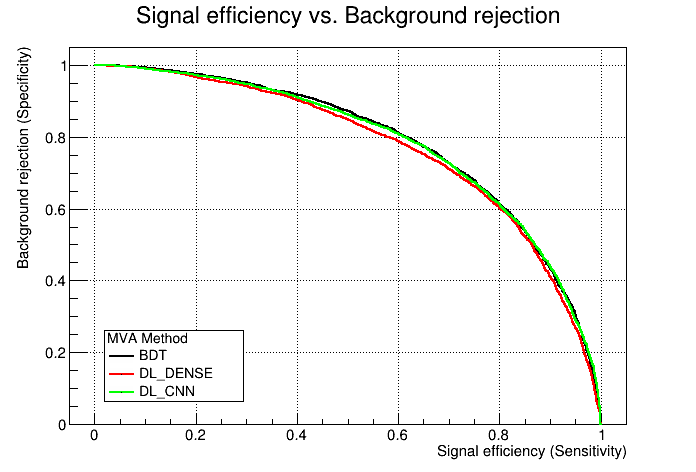

In [13]:
c1 = factory.GetROCCurve(loader);
c1->Draw();


In [14]:
// close outputfile to save output file
outputFile->Close();